Doubt</br>
How is activation function defined in PyTorch

## Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import time
import warnings
import math
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go
warnings.filterwarnings('ignore')
from copy import deepcopy

## Defining Functions

In [2]:
# Importing the dataset
def read_data(stock_name):
    """
    Reads the data from the path and returns a dataframe
    """
    df = pd.read_csv(f'/Users/advait_t/Desktop/Jio/Stock_Prediction/Stock_Prediction/data/raw/{stock_name}.csv')
    df = df[['Date','Close']]
    return df

In [3]:
def train_model(x_train,num_epochs,stock, y_train_lstm, learning_rate):
    """
    Trains the model and returns the model
    """
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

    hist = np.zeros(num_epochs)
    start_time = time.time()
    lstm = []

    for t in range(num_epochs):
        y_train_pred = model(x_train)

        loss = criterion(y_train_pred, y_train_lstm)
        print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))

    torch.save(deepcopy(model.state_dict()), f'/Users/advait_t/Desktop/Jio/Stock_Prediction/Stock_Prediction/models/best_model{stock}.pt') # official recommended
    return y_train_pred, hist, model, training_time, lstm

In [4]:
# Function to split data for LSTM model

def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [5]:
class LSTM(nn.Module):
    """
    Building the LSTM Model
    """
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [6]:
def plot_graphs(original, predict, hist):
    sns.set_style("darkgrid")    

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    plt.subplot(1, 2, 1)
    ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
    ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
    ax.set_title('Stock price', size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Cost (USD)", size = 14)
    ax.set_xticklabels('', size=10)


    plt.subplot(1, 2, 2)
    ax = sns.lineplot(data=hist, color='royalblue')
    ax.set_xlabel("Epoch", size = 14)
    ax.set_ylabel("Loss", size = 14)
    ax.set_title("Training Loss", size = 14, fontweight='bold')
    fig.set_figheight(6)
    fig.set_figwidth(16)

In [7]:
def make_prediction(model, x_test, y_test, y_train_lstm, y_test_lstm, y_train_pred, training_time, lstm, stock):

    # make predictions

    model.load_state_dict(torch.load(f'/Users/advait_t/Desktop/Jio/Stock_Prediction/Stock_Prediction/models/best_model{stock}.pt'))
    model.eval()
    y_test_pred = model(x_test)

    # invert predictions
    y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
    y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
    y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
    y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    lstm.append(trainScore)
    lstm.append(testScore)
    lstm.append(training_time)

    return y_train_pred, y_test_pred

In [8]:
def plotly_graph_for_visualisation(y_test_pred, y_train_pred):

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(price)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(price)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

    original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

    predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
    predictions = np.append(predictions, original, axis=1)
    result = pd.DataFrame(predictions)

    fig = go.Figure()
    fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                        mode='lines',
                        name='Train prediction')))
    fig.add_trace(go.Scatter(x=result.index, y=result[1],
                        mode='lines',
                        name='Test prediction'))
    fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                        mode='lines',
                        name='Actual Value')))
    fig.update_layout(
        xaxis=dict(
            title_text = 'Date',
            showline=True,
            showgrid=True,
            showticklabels=False,
            linecolor='white',
            linewidth=2
        ),
        yaxis=dict(
            title_text='Close (INR)',
            titlefont=dict(
                family='Rockwell',
                size=12,
                color='white',
            ),
            showline=True,
            showgrid=True,
            showticklabels=True,
            linecolor='white',
            linewidth=2,
            ticks='outside',
            tickfont=dict(
                family='Rockwell',
                size=12,
                color='white',
            ),
        ),
        showlegend=True,
        template = 'plotly_dark'

    )



    annotations = []
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                                xanchor='left', yanchor='bottom',
                                text='Results (LSTM)',
                                font=dict(family='Rockwell',
                                            size=26,
                                            color='white'),
                                showarrow=False))
    fig.update_layout(annotations=annotations)

    fig.show()

## Model Training and Validation

In [9]:
# Pass the stock name downloaded during data download
stock_name = 'RELIANCE'
data = read_data(stock_name)

In [10]:
price = data[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [11]:
lookback = 7 # last 7 days
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [12]:
# variables = [x_train, x_test, y_train, y_test]
# for i in variables:
#     i = torch.from_numpy(i).type(torch.Tensor)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [13]:
#passing the hyperparameters for the model training
input_dim = 1
hidden_dim = 64
num_layers = 8
output_dim = 1
num_epochs = 100
learning_rate = 0.01

In [14]:
y_train_pred, hist, model, training_time, lstm = train_model(x_train, num_epochs, stock_name, y_train, learning_rate)

Epoch  0 MSE:  0.1225246861577034
Epoch  1 MSE:  0.17713487148284912
Epoch  2 MSE:  0.126040980219841
Epoch  3 MSE:  0.12363307178020477
Epoch  4 MSE:  0.1263265311717987
Epoch  5 MSE:  0.12457316368818283
Epoch  6 MSE:  0.12273002415895462
Epoch  7 MSE:  0.12280943244695663
Epoch  8 MSE:  0.12280057370662689
Epoch  9 MSE:  0.12246587872505188
Epoch  10 MSE:  0.122624970972538
Epoch  11 MSE:  0.12258930504322052
Epoch  12 MSE:  0.1222846582531929
Epoch  13 MSE:  0.12165386229753494
Epoch  14 MSE:  0.12004033476114273
Epoch  15 MSE:  0.11523310840129852
Epoch  16 MSE:  0.10030141472816467
Epoch  17 MSE:  0.07191461324691772
Epoch  18 MSE:  0.0729375034570694
Epoch  19 MSE:  0.04671855270862579
Epoch  20 MSE:  0.062255751341581345
Epoch  21 MSE:  0.05512794852256775
Epoch  22 MSE:  0.04853779077529907
Epoch  23 MSE:  0.04579442739486694
Epoch  24 MSE:  0.048187125474214554
Epoch  25 MSE:  0.05005929619073868
Epoch  26 MSE:  0.04696664959192276
Epoch  27 MSE:  0.04433343559503555
Epoch  2

In [15]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

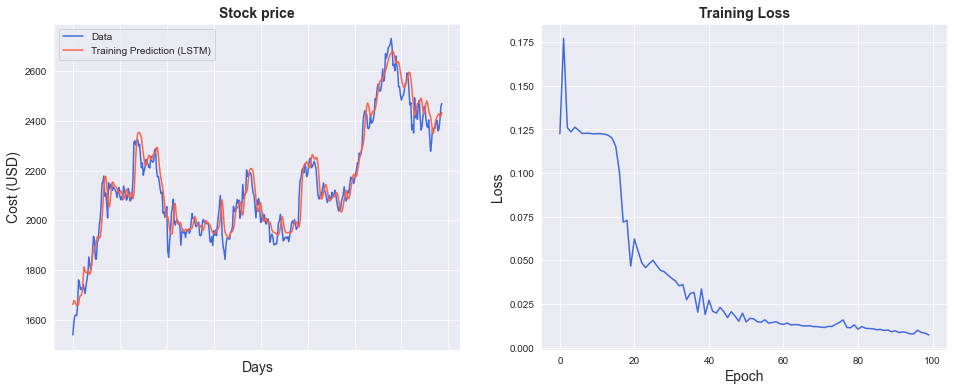

In [16]:
plot_graphs(original, predict, hist)

In [17]:
y_train_pred, y_test_pred = make_prediction(model, x_test, y_test, y_train, y_test, y_train_pred, training_time, lstm, stock_name)

Train Score: 54.76 RMSE
Test Score: 82.67 RMSE


In [18]:
plotly_graph_for_visualisation(y_test_pred, y_train_pred)